# Discover SWOT PIXC product: example over Quebec


![](https://img.shields.io/badge/CNES-tutorial-%20?color=blue&labelColor=grey)

_Authors: Damien Desroches, Mathilde Siméon (CNES)_
 
### Objectives
This tutorial explains  
* What is a PIXC product and how to manipulate it
* What are the most significant variables to use

### Requirements
1. Download SWOT products: 
   * Prior Lake database SWOT_LakeDatabaseSci_NA_72_20000101T000000_20991231T235959_20231017T000000_v105.sqlite
   * SWOT_L2_HR_PIXC_550_022_074L_20230613T041506_20230613T041517_PGC0_01.nc 
2. Run the notebook in `swot-training` environment


### Content
* [Product overview](#The-PIXC-product)
* [Setup](#Setup)
* [Reading the products](#Reading-the-products)
* [Visualize](#Visualize)



## The PIXC product

### Description
The PIXC is a medium size expert products providing access to full information for each pixels and a "land" buffer around the detected water.
Beware that there is a lot of information and flags to take into account.

<div>
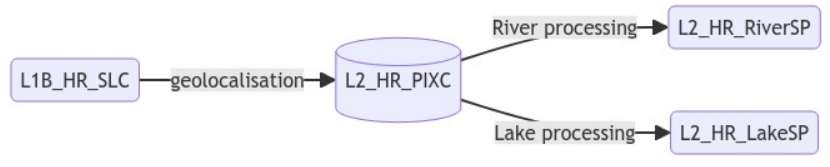
</div>


### When to use it ?

It can be useful for :
- Study of complex areas where specific averaging and agregation is needed (branded rivers, complex big lakes, wet lands, etc...)
- Study areas where water detection presents over_detection (wet banks, etc...) and where a complemantary filtering is needed
- alternative studies (ice, snow, etc...)
    
### Associated issues
As this product provides full information, is is necessary to consider
- consulting the [ATBD/PDD](https://podaac.jpl.nasa.gov/SWOT?tab=datasets-information) documents to understand what are the different fields in the product and how there are computed
- check which flags you should apply
- take into account that there is limited averaging  and no aggregation  

## Setup

In [1]:
import os
import datetime

import numpy as np
import xarray 
from netCDF4 import Dataset
import xarray as xr 
from scipy.ndimage import uniform_filter
from shapely.geometry import Polygon, box
import geopandas as gpd
import pandas
import shapefile
from scipy.signal import convolve2d
import sqlite3

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
workdir = '/work/EXPERT_CENTER/mwec/workspace/HR/tuto_ostst/data'

## Reading the products

### Reading the pixel cloud product

In [4]:
PIXCpath = f'{workdir}/SWOT_L2_HR_PIXC_550_022_074L_20230613T041506_20230613T041517_PGC0_01.nc'

In [5]:
root = xarray.open_dataset(PIXCpath)
ds = xarray.open_dataset(PIXCpath, group='pixel_cloud')

In [6]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:                                (points: 4977150, complex_depth: 2,
                                            num_pixc_lines: 3240)
Coordinates:
    latitude                               (points) float64 40MB ...
    longitude                              (points) float64 40MB ...
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 40MB ...
    range_index                            (points) float64 40MB ...
    interferogram                          (points, complex_depth) float32 40MB ...
    power_plus_y                           (points) float32 20MB ...
    power_minus_y                          (points) float32 20MB ...
    coherent_power                         (points) float32 20MB ...
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 26kB ...
    pixc_line_to_tvp                       (num_pixc_lines) float32 13kB ...
    data_window_first_valid                (num_pixc_lines) float64 26kB ...
    data_window_last_valid                 (num_pixc_lines) float64 26kB ...
    data_window_first_cross_track          (num_pixc_lines) float32 13kB ...
    data_window_last_cross_track           (num_pixc_lines) float32 13kB ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3240
    interferogram_size_range:    4726
    looks_to_efflooks:           1.5317059231344434
    num_azimuth_looks:           7.0
    azimuth_offset:              3

In [7]:
height = ds['height'][:]
classification = ds['classification'][:]
azimuth_index = ds['azimuth_index'][:]
power_plus_y = ds['power_plus_y'][:]
power_minus_y = ds['power_minus_y'][:]
range_index = ds['range_index'][:]
pixel_area = ds['pixel_area'][:]
interferogram = ds['interferogram'][:, 0] +1j*ds['interferogram'][:, 1] #Normalized radar cross section (sigma0) in real, linear units (not decibels). The value may be negative due to noise subtraction
incidence = ds['inc'][:]
sig0 = ds['sig0'][:]
latitude = ds['latitude'][:]
longitude = ds['longitude'][:]

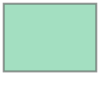

In [8]:
bounding_box= box(root.geospatial_lon_min, root.geospatial_lat_min, root.geospatial_lon_max, root.geospatial_lat_max)
bounding_box

### Read the Lake Prior Database

In [9]:
con = sqlite3.connect(f'{workdir}/SWOT_LakeDatabaseSci_NA_72_20000101T000000_20991231T235959_20231017T000000_v105.sqlite')
# Load geom extension
con.enable_load_extension(True)
con.execute('SELECT load_extension("mod_spatialite")')

# convert into pandas
raw_bdlake = pandas.read_sql_query("SELECT lake_id, basin_id, ST_AsBinary(ST_Multi(geometry)) as geometry FROM lake ;", con)
# convert geometries into shapely 
raw_bdlake['geometry'] = gpd.GeoSeries.from_wkb(raw_bdlake['geometry'])
bdlake = gpd.GeoDataFrame(raw_bdlake, geometry='geometry')

In [10]:
bdlake.head()

lake_id  basin_id                                           geometry
0  7210000012       721  MULTIPOLYGON (((-78.82973 49.11596, -78.83096 ...
1  7210000022       721  MULTIPOLYGON (((-79.22507 48.98265, -79.22835 ...
2  7210000032       721  MULTIPOLYGON (((-78.88752 48.91677, -78.88833 ...
3  7210000042       721  MULTIPOLYGON (((-78.93886 48.89314, -78.93927 ...
4  7210000052       721  MULTIPOLYGON (((-79.03661 49.19739, -79.03784 ...

Crop the  Lake Database to keep only the lakes that intersects the bounding box

In [11]:
df = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])
bd_lake_extract = gpd.clip(bdlake,df,keep_geom_type=True)

## Visualize

In [12]:
ind_water = np.logical_or((classification == 3), (classification == 4))

Text(203.72222222222223, 0.5, 'latitude')

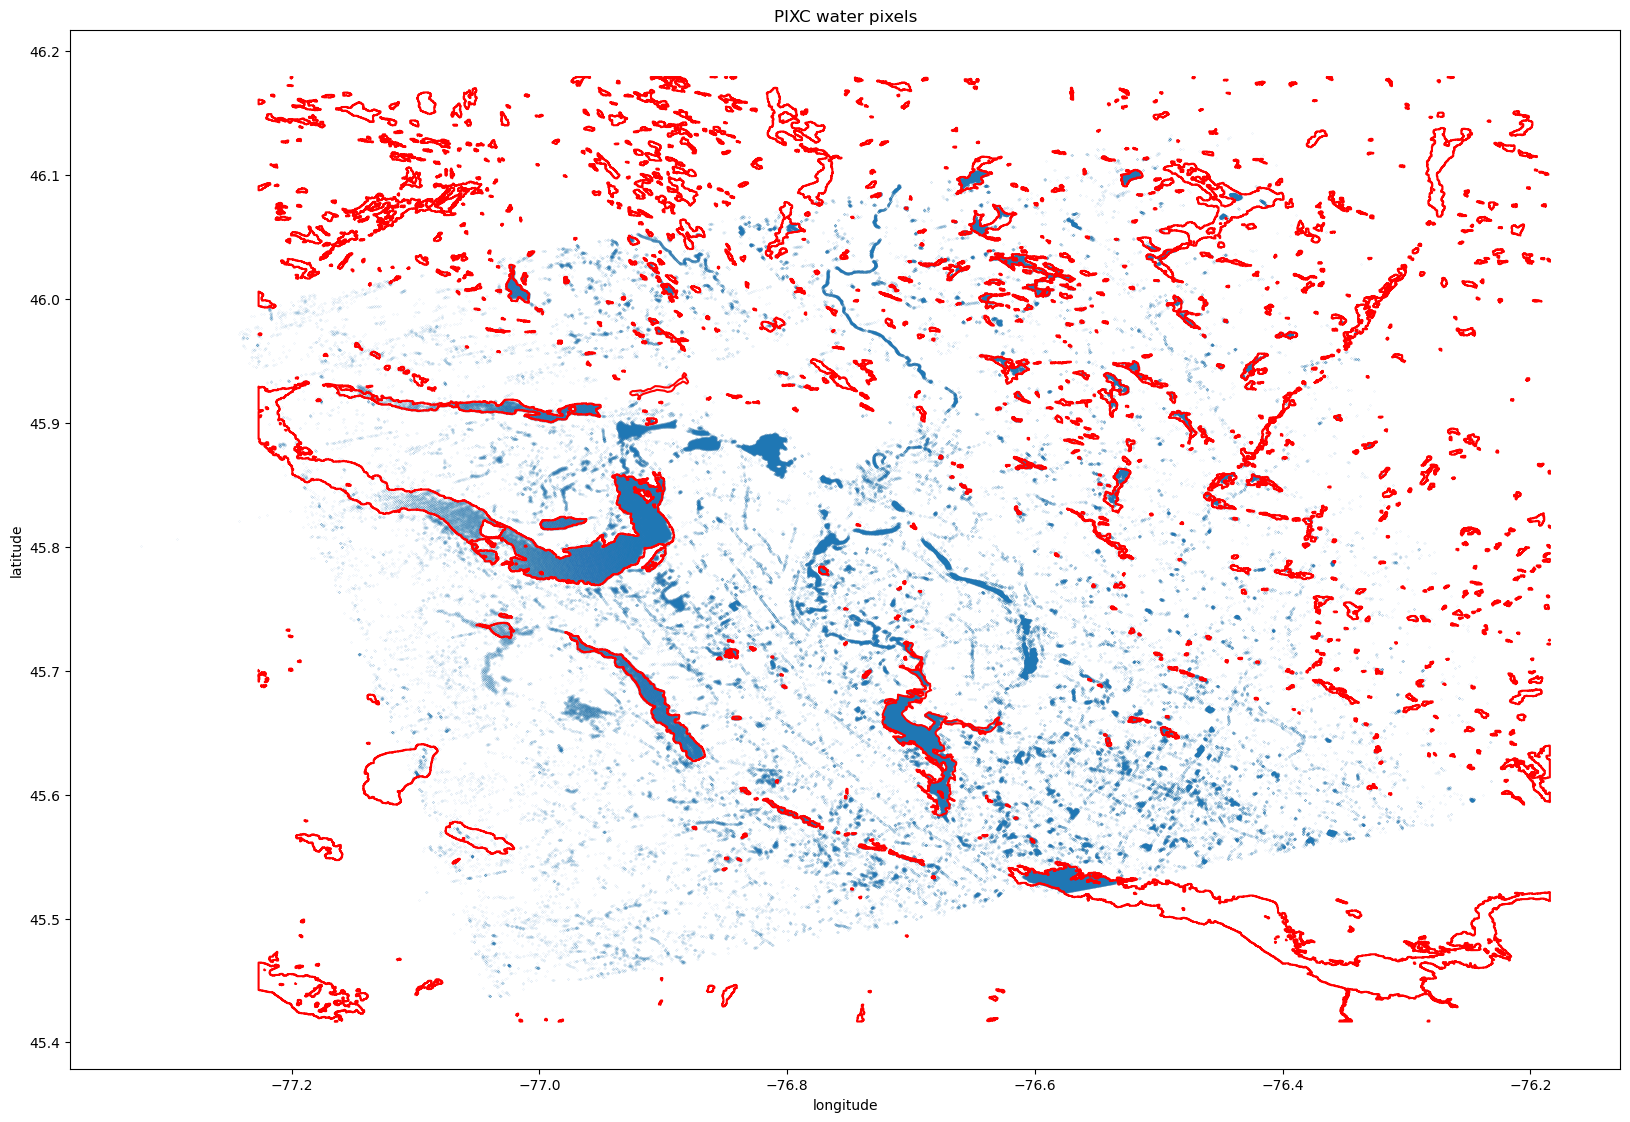

In [13]:
fig, ax = plt.subplots(figsize = (20,20)) 
plt.scatter(longitude[ind_water], latitude[ind_water], s=0.002)
bd_lake_extract.boundary.plot(color = 'r', ax=ax)
plt.title('PIXC water pixels')
plt.xlabel("longitude")
plt.ylabel("latitude")

Text(0.5, 1.0, 'PIXC water pixels (zoom)')

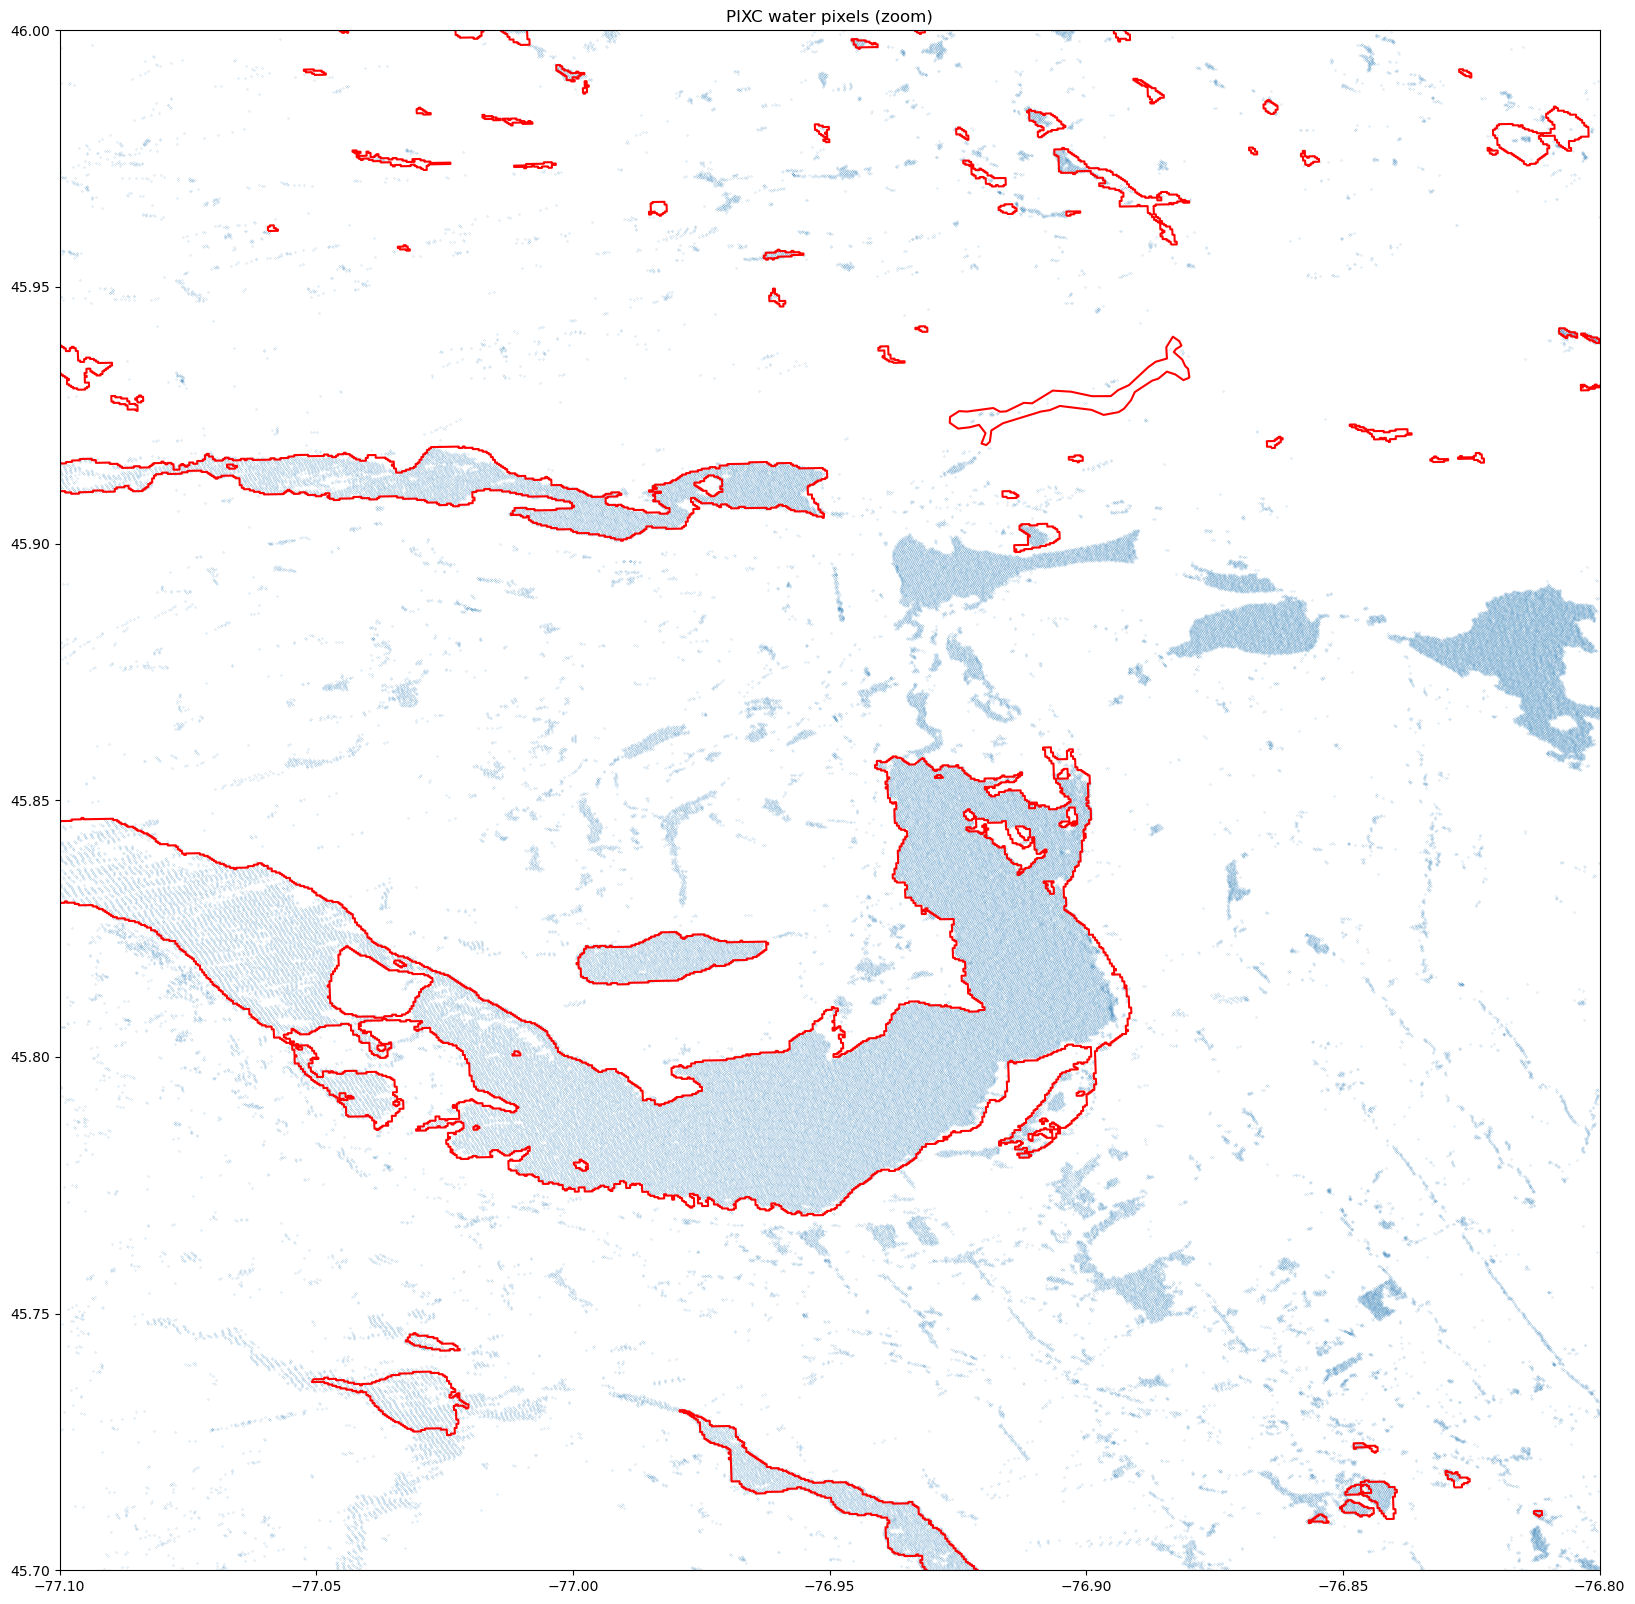

In [14]:
fig, ax = plt.subplots(figsize = (20,20)) 
plt.scatter(longitude[ind_water], latitude[ind_water], s=0.01)
ax.set_xlim(-77.1, -76.8)
ax.set_ylim(45.7,46.)
bd_lake_extract.boundary.plot(color = 'r', ax=ax)
plt.title('PIXC water pixels (zoom)')

Text(0.5, 1.0, 'PIXC water pixels (zoom)')

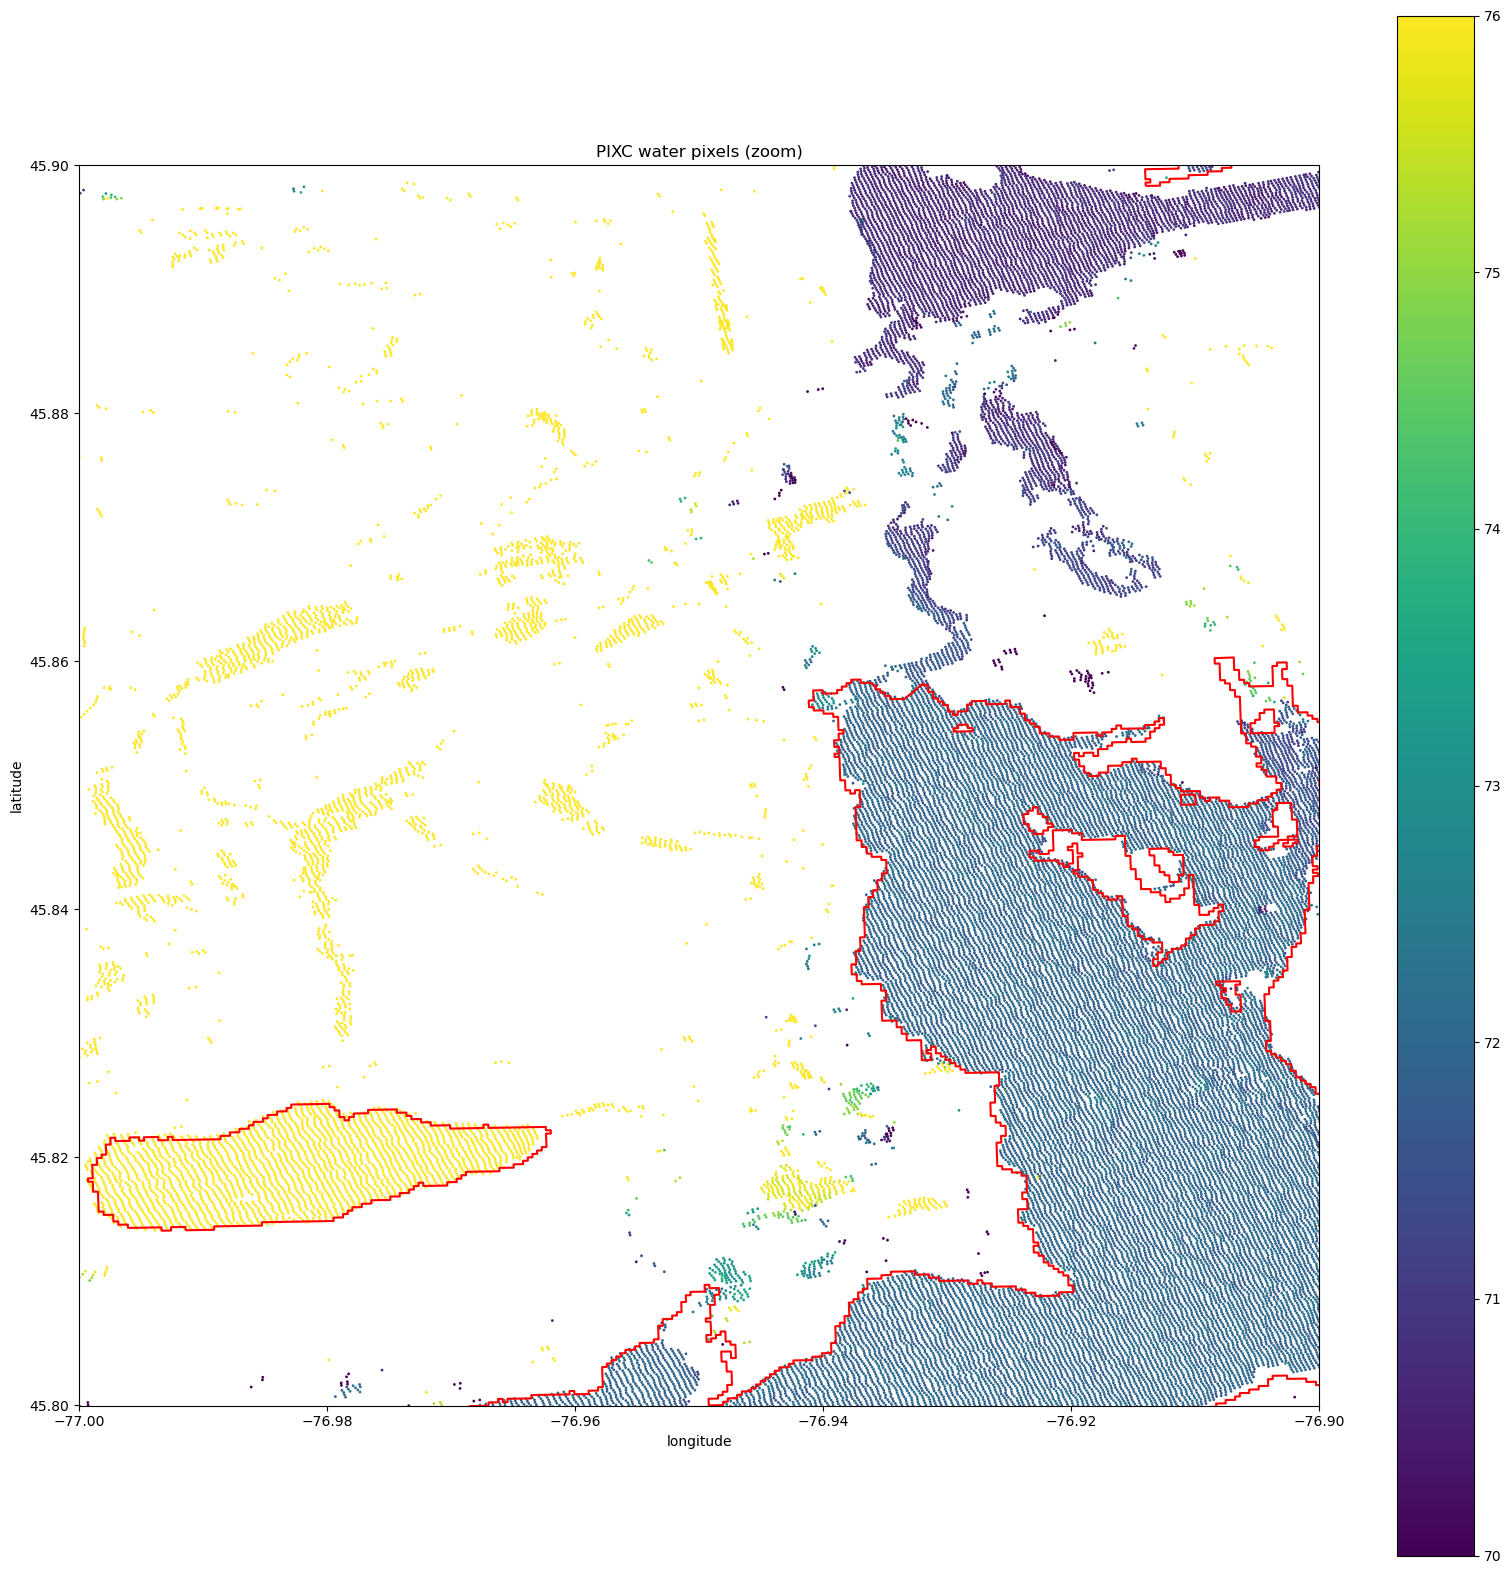

In [15]:
fig, ax = plt.subplots(figsize = (20,20)) 
plt.scatter(longitude[ind_water], latitude[ind_water], c=height[ind_water], s=1, vmin=70, vmax=76)
plt.colorbar()
ax.set_xlim(-77., -76.9)
ax.set_ylim(45.8,45.9)
plt.xlabel("longitude")
plt.ylabel("latitude")
bd_lake_extract.boundary.plot(color = 'r', ax=ax)
plt.title('PIXC water pixels (zoom)')

/work/softs/vre/projets/swotce/exploitation/envs/ceswot-stable/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


Text(0.5, 1.0, 'PIXC water pixels (zoom) : Sigma 0 (dB)')

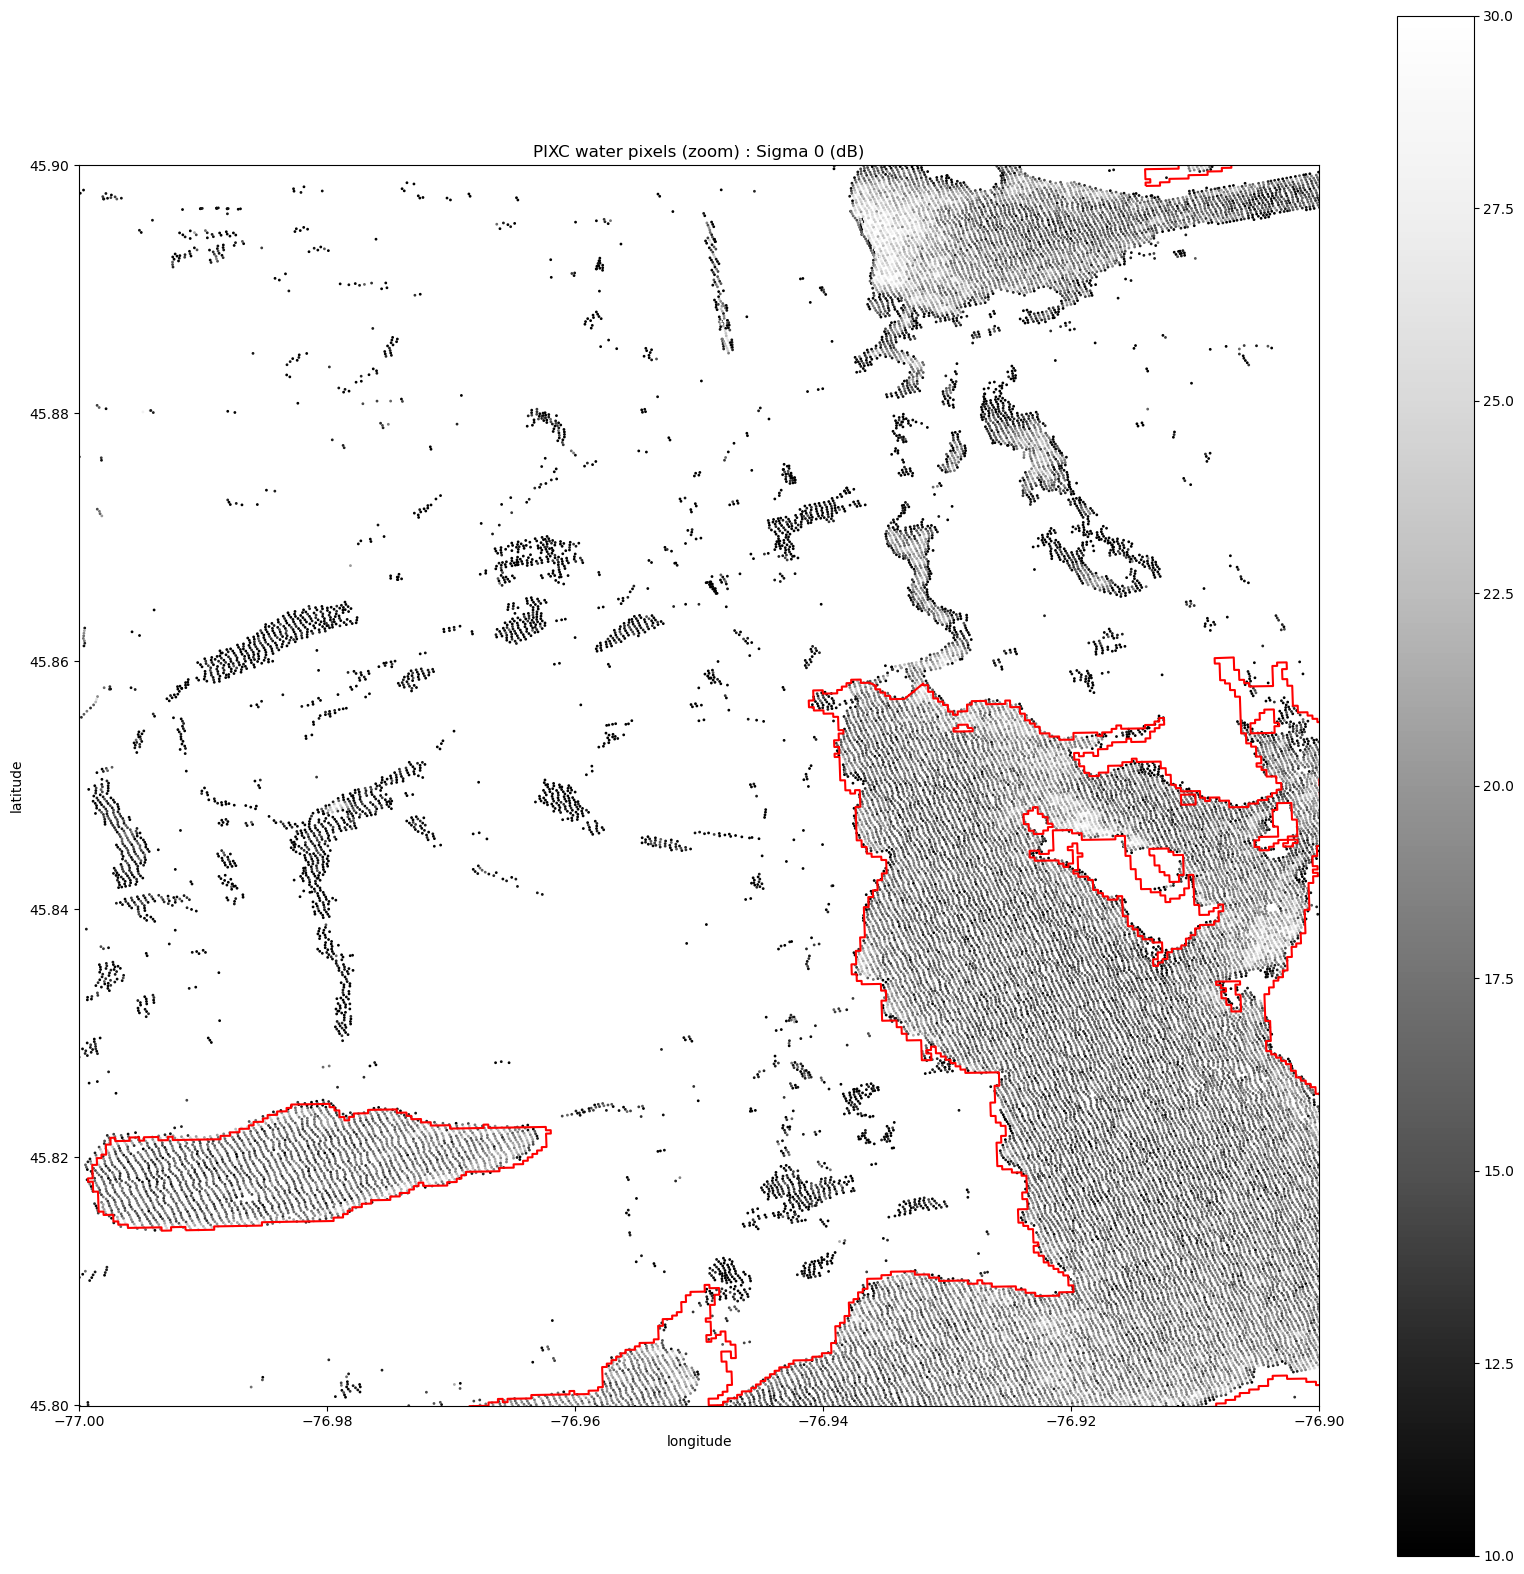

In [16]:
fig, ax = plt.subplots(figsize = (20,20)) 
plt.scatter(longitude[ind_water], latitude[ind_water], c=10*np.log10(sig0[ind_water]), s=1, vmin=10, vmax=30,  cmap = "Greys_r")
plt.colorbar()
ax.set_xlim(-77., -76.9)
ax.set_ylim(45.8,45.9)
plt.xlabel("longitude")
plt.ylabel("latitude")
bd_lake_extract.boundary.plot(color = 'r', ax=ax)
plt.title('PIXC water pixels (zoom) : Sigma 0 (dB)')

## Reprojection in SAR geometry

In [ ]:
dims = [ds.interferogram_size_azimuth, ds.interferogram_size_range ]
sig0_tab = np.zeros(dims)
classif_tab = np.zeros(dims)
power_plus_y_tab = np.zeros(dims)
power_minus_y_tab = np.zeros(dims)
interferogram_tab = np.zeros(dims, dtype= complex)
height_tab = np.zeros(dims, dtype= complex)

azimuth_index = ds.variables['azimuth_index'][:]
range_index = ds.variables['range_index'][:]

for i in range(len(sig0)):
    a=int(azimuth_index[i])
    r=int(range_index[i])
    sig0_tab[a, r] = sig0[i]  
    
    classif_tab[a, r] = classification[i]
    power_plus_y_tab[a, r] = power_plus_y[i]
    power_minus_y_tab[a, r] = power_minus_y[i]
    interferogram_tab[a, r] = interferogram[i]
    height_tab[a, r] = height[i]
    

In [ ]:
kernel = np.ones([3,3])

interferogram =  convolve2d(interferogram_tab, kernel, mode='same')
slc_1_power = convolve2d(power_minus_y_tab, kernel, mode='same')
slc_2_power = convolve2d(power_plus_y_tab, kernel, mode='same')
coherence = np.abs(interferogram) / np.sqrt((slc_1_power) * (slc_2_power))

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(10*np.log10(power_plus_y_tab[800:1500,1000:1700]), cmap="Greys_r")
plt.title("power_plus")
plt.xlabel("range index")
plt.ylabel("azimuth index")
plt.colorbar()

plt.figure(figsize=(15,15))
plt.imshow(classif_tab[800:1500,1000:1700], cmap="Spectral")
plt.title("classification map")
plt.xlabel("range index")
plt.ylabel("azimuth index")
plt.colorbar()

plt.figure(figsize=(15,15))
plt.imshow(coherence[800:1500,1000:1700], cmap="Greys_r")
plt.title("interferometric coherence")
plt.xlabel("range index")
plt.ylabel("azimuth index")
plt.colorbar()